### Bartlett experiment with GPT-2

* Fine-tune GPT-2 on Bartlett experiment story plus 'cultural context'
* Explore recall of Bartlett story
* How does temperature parameter for sampling explore level of distortion?

In [4]:
!pip install simpletransformers
!pip install tensorflow
!pip install tensorflow_datasets
!pip install wordcloud

  Using cached simpletransformers-0.60.9-py3-none-any.whl (206 kB)
  Using cached wandb-0.10.20-py2.py3-none-any.whl (2.0 MB)
  Using cached tensorboardX-2.1-py2.py3-none-any.whl (308 kB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached streamlit-0.77.0-py2.py3-none-any.whl (7.5 MB)
  Using cached sentencepiece-0.1.95-cp36-cp36m-manylinux2014_x86_64.whl (1.2 MB)
  Using cached dataclasses-0.8-py3-none-any.whl (19 kB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached tzlocal-2.1-py2.py3-none-any.whl (16 kB)
  Using cached blinker-1.4-py3-none-any.whl
  Using cached pydeck-0.6.1-py2.py3-none-any.whl (4.6 MB)
  Using cached validators-0.18.2-py3-none-any.whl (19 kB)
  Using cached GitPython-3.1.14-py3-none-any.whl (159 kB)
  Using cached altair-4.1.0-py3-none-any.whl (727 kB)
  Using cached cachetools-4.2.1-py3-none-any.whl (12 kB)
  Using cached base58-2.1.0-py3-none-any.whl (5.6 kB)
  Using cached gitdb-4.0.5-py3-none-any.whl (63 kB)
  Using cached smmap

In [5]:
import tensorflow_datasets as tfds

ds = tfds.load('cnn_dailymail', split='train')

articles = []
for example in ds: 
    articles.append(example["article"].numpy().decode("utf-8"))
    
print(len(articles))

287113


In [6]:
bartlett = ["One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm.", 
            "Then they heard war-cries, and they thought: 'Maybe this is a war-party'.",
            "They escaped to the shore, and hid behind a log.",
            "Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them.",
            "There were five men in the canoe, and they said:"
            "What do you think? We wish to take you along. We are going up the river to make war on the people.",
            "One of the young men said,'I have no arrows.'",
            "'Arrows are in the canoe,'' they said.",
            "'I will not go along. I might be killed. My relatives do not know where I have gone. But you,' he said, turning to the other, 'may go with them.'",
            "So one of the young men went, but the other returned home.",
            "And the warriors went on up the river to a town on the other side of Kalama."
            "The people came down to the water and they began to fight, and many were killed."
            "But presently the young man heard one of the warriors say, 'Quick, let us go home: that man has been hit.'", 
            "Now he thought: 'Oh, they are ghosts.' He did not feel sick, but they said he had been shot.",
            "So the canoes went back to Egulac and the young man went ashore to his house and made a fire.",
            "And he told everybody and said: 'Behold I accompanied the ghosts, and we went to fight. Many of our fellows were killed, and many of those who attacked us were killed. They said I was hit, and I did not feel sick.'",
            "He told it all, and then he became quiet. When the sun rose he fell down.", 
            "Something black came out of his mouth. His face became contorted. The people jumped up and cried. He was dead."
           ]

#### Provide time and location as context

In [82]:
import urllib
import random

data = urllib.request.urlopen("https://raw.githubusercontent.com/navchandar/Python-Random-Name-Generator/master/Names/PlaceNames.txt").read() # read only 20 000 chars
places_list = data.decode('utf-8').replace('\r', '').split("\n") # then split it into lines

In [83]:
from random import randrange
from datetime import timedelta
from datetime import datetime

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

d1 = datetime.strptime('1/1/2000 12:00 PM', '%m/%d/%Y %I:%M %p')
d2 = datetime.strptime('1/1/2021 12:00 AM', '%m/%d/%Y %I:%M %p')

print(random_date(d1, d2))

2007-12-07 16:02:35


In [99]:
sents_list = []

for a in articles:
    sents = a.split('. ')
    sents_list.extend([s for s in sents if len(s) >100])

In [106]:
filtered = [s for s in sents_list if 'kill' in s][0:10000]

In [116]:
sents_list = filtered[0:100] + bartlett
sents_list[-5:]

["Now he thought: 'Oh, they are ghosts.' He did not feel sick, but they said he had been shot.",
 'So the canoes went back to Egulac and the young man went ashore to his house and made a fire.',
 "And he told everybody and said: 'Behold I accompanied the ghosts, and we went to fight. Many of our fellows were killed, and many of those who attacked us were killed. They said I was hit, and I did not feel sick.'",
 'He told it all, and then he became quiet. When the sun rose he fell down.',
 'Something black came out of his mouth. His face became contorted. The people jumped up and cried. He was dead.']

In [117]:
with open('data/train.txt', 'w') as fh:
    fh.write('\n'.join(sents_list))
    
with open('data/test.txt', 'w') as fh:
    fh.write('\n'.join(sents_list))

#### Train model

In [136]:
import logging

from simpletransformers.language_modeling import (
    LanguageModelingModel,
    LanguageModelingArgs,
)

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

model_args = LanguageModelingArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.num_train_epochs = 400
model_args.dataset_type = "simple"
model_args.mlm = False  # mlm must be False for CLM
model_args.fp16=False
#model_args.vocab_size = 30000
model_args.save_model_every_epoch = False
model_args.save_best_model = True

train_file = "data/train.txt"
test_file = "data/test.txt"

model = LanguageModelingModel(
    "gpt2", "gpt2", args=model_args, use_cuda=True, train_files=train_file, 
)

# Train the model
model.train_model(train_file, eval_file=test_file)

# Evaluate the model
result = model.eval_model(test_file)

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_train.txt
INFO:simpletransformers.language_modeling.language_modeling_model: Training started


Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Running Epoch 0 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 2 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 3 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 4 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 5 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 6 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 7 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 8 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 9 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 10 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 11 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 12 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 13 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 14 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 15 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 16 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 17 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 18 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 19 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 20 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 21 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 22 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 23 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 24 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 25 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 26 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 27 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 28 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 29 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 30 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 31 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 32 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 33 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 34 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 35 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 36 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 37 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 38 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 39 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 40 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 41 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 42 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 43 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 44 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 45 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 46 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 47 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 48 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 49 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 50 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 51 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 52 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 53 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 54 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 55 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 56 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 57 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 58 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 59 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 60 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 61 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 62 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 63 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 64 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 65 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 66 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 67 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 68 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 69 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 70 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 71 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 72 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 73 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 74 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 75 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 76 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 77 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 78 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 79 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 80 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 81 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 82 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 83 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 84 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 85 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 86 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 87 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 88 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 89 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 90 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 91 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 92 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 93 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 94 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 95 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 96 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 97 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 98 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 99 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 100 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 101 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 102 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 103 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 104 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 105 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 106 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 107 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 108 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 109 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 110 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 111 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 112 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 113 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 114 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 115 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 116 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 117 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 118 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 119 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 120 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 121 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 122 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 123 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 124 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 125 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 126 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 127 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 128 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 129 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 130 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 131 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 132 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 133 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 134 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 135 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 136 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 137 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 138 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 139 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 140 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 141 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 142 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 143 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 144 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 145 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 146 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 147 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 148 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 149 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 150 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 151 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 152 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 153 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 154 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 155 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 156 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 157 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 158 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 159 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 160 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 161 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 162 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 163 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 164 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 165 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 166 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 167 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 168 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 169 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 170 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 171 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 172 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 173 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 174 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 175 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 176 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 177 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 178 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 179 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 180 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 181 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 182 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 183 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 184 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 185 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 186 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 187 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 188 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 189 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 190 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 191 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 192 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 193 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 194 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 195 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 196 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 197 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 198 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 199 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 200 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 201 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 202 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 203 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 204 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 205 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 206 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 207 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 208 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 209 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 210 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 211 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 212 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 213 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 214 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 215 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 216 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 217 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 218 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 219 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 220 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 221 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 222 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 223 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 224 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 225 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 226 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 227 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 228 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 229 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 230 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 231 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 232 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 233 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 234 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 235 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 236 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 237 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 238 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 239 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 240 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 241 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 242 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 243 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 244 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 245 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 246 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 247 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 248 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 249 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 250 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 251 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 252 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 253 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 254 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 255 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 256 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 257 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 258 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 259 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 260 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 261 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 262 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 263 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 264 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 265 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 266 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 267 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 268 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 269 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 270 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 271 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 272 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 273 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 274 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 275 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 276 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 277 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 278 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 279 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 280 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 281 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 282 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 283 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 284 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 285 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 286 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 287 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 288 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 289 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 290 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 291 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 292 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 293 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 294 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 295 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 296 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 297 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 298 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 299 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 300 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 301 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 302 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 303 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 304 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 305 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 306 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 307 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 308 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 309 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 310 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 311 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 312 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 313 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 314 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 315 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 316 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 317 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 318 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 319 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 320 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 321 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 322 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 323 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 324 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 325 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 326 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 327 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 328 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 329 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 330 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 331 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 332 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 333 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 334 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 335 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 336 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 337 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 338 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 339 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 340 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 341 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 342 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 343 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 344 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 345 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 346 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 347 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 348 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 349 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 350 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 351 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 352 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 353 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 354 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 355 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 356 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 357 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 358 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 359 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 360 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 361 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 362 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 363 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 364 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 365 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 366 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 367 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 368 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 369 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 370 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 371 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 372 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 373 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 374 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 375 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 376 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 377 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 378 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 379 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 380 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 381 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 382 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 383 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 384 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 385 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 386 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 387 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 388 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 389 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 390 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 391 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 392 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 393 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 394 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 395 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 396 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 397 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 398 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 399 of 400:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_model: Training of gpt2 model complete. Saved to outputs/.
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_model:{'eval_loss': 0.002050214831251651, 'perplexity': tensor(1.0021)}


#### Explore recall of story using trained model

In [8]:
from simpletransformers.language_generation import LanguageGenerationModel, LanguageGenerationArgs
import logging

def generate_with_params(temperature=1.0):
    model_args = LanguageGenerationArgs()
    model_args.temperature = temperature
    model_args.do_sampling= True
    model_args.max_length = 500
    model_args.num_beams = 1
    model_args.repetition_penalty = 1.05
    model_args.top_k = 50

    model = LanguageGenerationModel("gpt2", "./outputs_set_1/", args=model_args)
    
    return model.generate(bartlett[0])

In [9]:
generated = {}
generated['set_1'] = {}

for i in [0.1,0.5,1.0,1.5,2.0]:
    gen_list = []
    for n in range(4):
        gen_list.append(generate_with_params(temperature=i))
    generated['set_1'][i] = gen_list

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [24]:
#generated['set_1'][0.5][1]
#generated['set_1'][1.5][1]
generated['set_1'][1.5][2]

["One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm.Then they heard war-cries, and they thought: 'Maybe this is a war-party'.They escaped to the shore, and hid behind a log.Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them.There were five men in the canoe, and they said:What do you think? We wish to take you along. We are going up the river to make war on the people.One of the young men said,'I have no quarrel with you,' and pointed out to the other: 'You are a spy.'So the young man said,'I have no quarrel with you,' and replied: 'If I may say so, I will.'So the canoe went back up the river to a town on the other side of Kalama.The people came down to the water, and they began to fight, and many were killed.But presently the young man heard one of the warriors say,'Quick, let us go home: that man has no fear of the people. He has no fear of the sun, and he has no desire 

Temperature = 0.1:


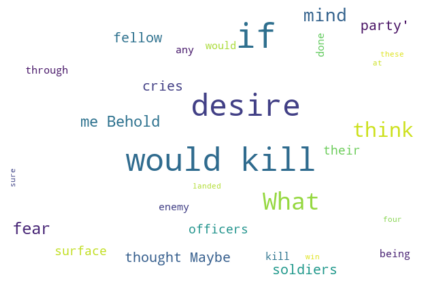

Temperature = 0.5:


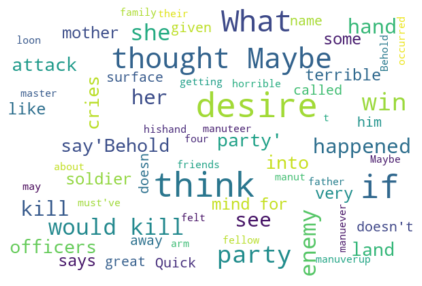

Temperature = 1.0:


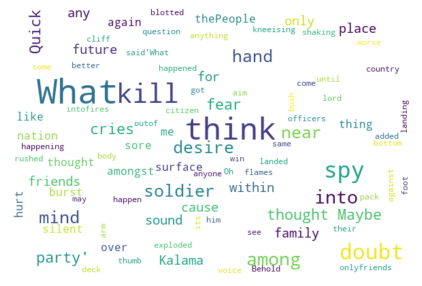

Temperature = 1.5:


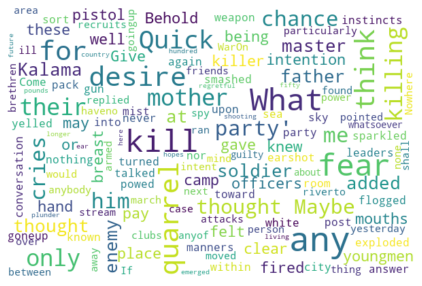

Temperature = 2.0:


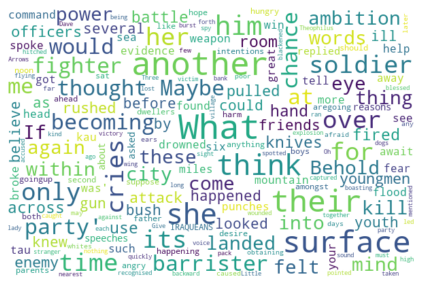

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

bartlett_stopwords = ' '.join(bartlett).replace('.', '').replace(',', '').split()

for temp in [0.1,0.5,1.0,1.5,2.0]:
    print("Temperature = {}:".format(temp))
    items = [item[0] for item in generated['set_1'][temp]]
    text = ' '.join(items)

    wordcloud = WordCloud(width=600, height=400, background_color="white", max_font_size=50, stopwords=bartlett_stopwords).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()